In [43]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from astral import LocationInfo
from astral.sun import sun
import pytz

import pandas as pd
from datetime import datetime
from meteostat import Point, Hourly

import warnings
warnings.filterwarnings('ignore')


In [44]:
df = pd.read_csv('data.csv')

In [45]:
df.head()

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
0,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
1,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
2,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
3,01 01 2018 00:30,419.645905,5.659674,516.127569,271.258087
4,01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286


In [46]:
df.shape

(50530, 5)

# Data Information

### Context

In Wind Turbines, Scada Systems measure and save data's like wind speed, wind direction, generated power etc. for 10 minutes intervals. This file was taken from a wind turbine's scada system that is working and generating power in Turkey.

### Content

The data's in the file are:

**Date/Time** (for 10 minutes intervals)

**LV ActivePower (kW)**: The power generated by the turbine for that moment

**Wind Speed (m/s)**: The wind speed at the hub height of the turbine (the wind speed that turbine use for electricity generation)

**Theoretical_Power_Curve (KWh)**: The theoretical power values that the turbine generates with that wind speed which is given by the turbine manufacturer

**Wind Direction (°)**: The wind direction at the hub height of the turbine (wind turbines turn to this direction automaticly)

In [47]:
# number of missing value
df.isna().sum()

Date/Time                        0
LV ActivePower (kW)              0
Wind Speed (m/s)                 0
Theoretical_Power_Curve (KWh)    0
Wind Direction (°)               0
dtype: int64

In [48]:
# number of duplicates
df.duplicated().sum()

np.int64(0)

In [49]:
# Check Null and Dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50530 entries, 0 to 50529
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Date/Time                      50530 non-null  object 
 1   LV ActivePower (kW)            50530 non-null  float64
 2   Wind Speed (m/s)               50530 non-null  float64
 3   Theoretical_Power_Curve (KWh)  50530 non-null  float64
 4   Wind Direction (°)             50530 non-null  float64
dtypes: float64(4), object(1)
memory usage: 1.9+ MB


In [50]:
# number of unique values
df.nunique()

Date/Time                        50530
LV ActivePower (kW)              38764
Wind Speed (m/s)                 50305
Theoretical_Power_Curve (KWh)    37157
Wind Direction (°)               50251
dtype: int64

In [51]:
df.describe()

,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
count,50530.000000,50530.000000,50530.000000,50530.000000
mean,1307.684332,7.557952,1492.175463,123.687559
std,1312.459242,4.227166,1368.018238,93.443736
min,-2.471405,0.000000,0.000000,0.000000
25%,50.677890,4.201395,161.328167,49.315437
50%,825.838074,7.104594,1063.776283,73.712978
75%,2482.507568,10.300020,2964.972462,201.696720
max,3618.732910,25.206011,3600.000000,359.997589


In [52]:
# define numerical & categorical columns
numeric_features = [feature for feature in df.columns if df[feature].dtype != 'O']
categorical_features = [feature for feature in df.columns if df[feature].dtype == 'O']

# print columns
print('We have {} numerical features : {}'.format(len(numeric_features), numeric_features))
print('\nWe have {} categorical features : {}'.format(len(categorical_features), categorical_features))

We have 4 numerical features : ['LV ActivePower (kW)', 'Wind Speed (m/s)', 'Theoretical_Power_Curve (KWh)', 'Wind Direction (°)']

We have 1 categorical features : ['Date/Time']


In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50530 entries, 0 to 50529
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Date/Time                      50530 non-null  object 
 1   LV ActivePower (kW)            50530 non-null  float64
 2   Wind Speed (m/s)               50530 non-null  float64
 3   Theoretical_Power_Curve (KWh)  50530 non-null  float64
 4   Wind Direction (°)             50530 non-null  float64
dtypes: float64(4), object(1)
memory usage: 1.9+ MB


In [54]:
#dataset['Date/Time'] is object 
df['Date/Time'] = pd.to_datetime(df['Date/Time'], format='%d %m %Y %H:%M')

min in LV columns >>>> -2.471405

In Active power LV Describe() min value is negative, this means wind turbine sometimes is consuming power rather than generating it.

#### This situation can occur under several conditions:
1- Start-Up Phase: During the initial start-up phase, the turbine may draw power from the grid to initiate the rotation of the blades until the wind speed is sufficient for self-sustained operation.

2- Low Wind Conditions: When wind speeds are too low to generate sufficient power, the turbine may consume power to maintain its systems and control mechanisms.

3- Maintenance or Shutdown: During maintenance or shutdown periods, the turbine might use power for essential operations like braking systems, yaw control, and monitoring equipment.

4- Grid Support: In some cases, wind turbines can provide ancillary services to the grid, such as reactive power support or voltage regulation, which might involve consuming power temporarily.

Negative values in active power readings are a normal part of wind turbine operation under certain conditions and help operators understand the turbine's behavior and energy balance.

In [55]:
#replace negative values with mean
df.loc[df['LV ActivePower (kW)'] < 0, 'LV ActivePower (kW)'] = 1307.684332
df.describe()

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
count,50530,50530.000000,50530.000000,50530.000000,50530.000000
mean,2018-07-01 20:01:30.065307648,1309.159823,7.557952,1492.175463,123.687559
min,2018-01-01 00:00:00,0.000000,0.000000,0.000000,0.000000
25%,2018-04-03 05:22:30,53.204888,4.201395,161.328167,49.315437
50%,2018-06-30 16:15:00,829.766357,7.104594,1063.776283,73.712978
75%,2018-09-26 18:57:30,2482.507568,10.300020,2964.972462,201.696720
max,2018-12-31 23:50:00,3618.732910,25.206011,3600.000000,359.997589
std,NaN,1311.722947,4.227166,1368.018238,93.443736


In [56]:
df['Month'] = df['Date/Time'].dt.month
df['week'] = df['Date/Time'].dt.isocalendar().week
df['day'] = df['Date/Time'].dt.day
df['Hour']=df['Date/Time'].dt.hour
df.head(20)

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°),Month,week,day,Hour
0,2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904,1,1,1,0
1,2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113,1,1,1,0
2,2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789,1,1,1,0
3,2018-01-01 00:30:00,419.645905,5.659674,516.127569,271.258087,1,1,1,0
4,2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286,1,1,1,0
5,2018-01-01 00:50:00,402.391998,5.604052,499.436385,264.578613,1,1,1,0
6,2018-01-01 01:00:00,447.605713,5.793008,557.372363,266.163605,1,1,1,1
7,2018-01-01 01:10:00,387.242188,5.306050,414.898179,257.949493,1,1,1,1
8,2018-01-01 01:20:00,463.651215,5.584629,493.677652,253.480698,1,1,1,1
9,2018-01-01 01:30:00,439.725708,5.523228,475.706783,258.723785,1,1,1,1


In [57]:
seasons_dict = {1: 'Winter', 2: 'Winter', 3: 'Winter', 4: 'Spring', 5: 'Spring', 6: 'Summer', 7: 'Summer', 8: 'Summer', 9: 'Autumn', 10: 'Autumn', 11: 'Autumn', 12: 'Winter'}

df['Seasons'] = df['Month'].map(seasons_dict)
df

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°),Month,week,day,Hour,Seasons
0,2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904,1,1,1,0,Winter
1,2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113,1,1,1,0,Winter
2,2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789,1,1,1,0,Winter
3,2018-01-01 00:30:00,419.645905,5.659674,516.127569,271.258087,1,1,1,0,Winter
4,2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286,1,1,1,0,Winter
...,...,...,...,...,...,...,...,...,...,...
50525,2018-12-31 23:10:00,2963.980957,11.404030,3397.190793,80.502724,12,1,31,23,Winter
50526,2018-12-31 23:20:00,1684.353027,7.332648,1173.055771,84.062599,12,1,31,23,Winter
50527,2018-12-31 23:30:00,2201.106934,8.435358,1788.284755,84.742500,12,1,31,23,Winter
50528,2018-12-31 23:40:00,2515.694092,9.421366,2418.382503,84.297913,12,1,31,23,Winter


In [58]:
# Cyclical time features
df['hour_sin'] = np.sin(2*np.pi*df['Hour']/24)
df['hour_cos'] = np.cos(2*np.pi*df['Hour']/24)
df['month_sin'] = np.sin(2*np.pi*(df['Month']-1)/12)
df['month_cos'] = np.cos(2*np.pi*(df['Month']-1)/12)
df

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°),Month,week,day,Hour,Seasons,hour_sin,hour_cos,month_sin,month_cos
0,2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904,1,1,1,0,Winter,0.000000,1.000000,0.0,1.000000
1,2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113,1,1,1,0,Winter,0.000000,1.000000,0.0,1.000000
2,2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789,1,1,1,0,Winter,0.000000,1.000000,0.0,1.000000
3,2018-01-01 00:30:00,419.645905,5.659674,516.127569,271.258087,1,1,1,0,Winter,0.000000,1.000000,0.0,1.000000
4,2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286,1,1,1,0,Winter,0.000000,1.000000,0.0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50525,2018-12-31 23:10:00,2963.980957,11.404030,3397.190793,80.502724,12,1,31,23,Winter,-0.258819,0.965926,-0.5,0.866025
50526,2018-12-31 23:20:00,1684.353027,7.332648,1173.055771,84.062599,12,1,31,23,Winter,-0.258819,0.965926,-0.5,0.866025
50527,2018-12-31 23:30:00,2201.106934,8.435358,1788.284755,84.742500,12,1,31,23,Winter,-0.258819,0.965926,-0.5,0.866025
50528,2018-12-31 23:40:00,2515.694092,9.421366,2418.382503,84.297913,12,1,31,23,Winter,-0.258819,0.965926,-0.5,0.866025


In [59]:
# Wind vector components (u,v)
rad = np.deg2rad(df['Wind Direction (°)'])
df['wind_u'] = df['Wind Speed (m/s)'] * np.cos(rad)
df['wind_v'] = df['Wind Speed (m/s)'] * np.sin(rad)
df

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°),Month,week,day,Hour,Seasons,hour_sin,hour_cos,month_sin,month_cos,wind_u,wind_v
0,2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904,1,1,1,0,Winter,0.000000,1.000000,0.0,1.000000,-0.922769,-5.230563
1,2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113,1,1,1,0,Winter,0.000000,1.000000,0.0,1.000000,-0.134514,-5.670572
2,2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789,1,1,1,0,Winter,0.000000,1.000000,0.0,1.000000,0.233413,-5.210812
3,2018-01-01 00:30:00,419.645905,5.659674,516.127569,271.258087,1,1,1,0,Winter,0.000000,1.000000,0.0,1.000000,0.124264,-5.658310
4,2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286,1,1,1,0,Winter,0.000000,1.000000,0.0,1.000000,-0.420723,-5.562052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50525,2018-12-31 23:10:00,2963.980957,11.404030,3397.190793,80.502724,12,1,31,23,Winter,-0.258819,0.965926,-0.5,0.866025,1.881673,11.247720
50526,2018-12-31 23:20:00,1684.353027,7.332648,1173.055771,84.062599,12,1,31,23,Winter,-0.258819,0.965926,-0.5,0.866025,0.758502,7.293312
50527,2018-12-31 23:30:00,2201.106934,8.435358,1788.284755,84.742500,12,1,31,23,Winter,-0.258819,0.965926,-0.5,0.866025,0.772948,8.399870
50528,2018-12-31 23:40:00,2515.694092,9.421366,2418.382503,84.297913,12,1,31,23,Winter,-0.258819,0.965926,-0.5,0.866025,0.936069,9.374748


In [60]:
# Turbulence / variability / gust features (rolling)
## (10-min data → window sizes in observations: 6 → 1h, 36 → 6h, etc.)
df['wind_mean_1h'] = df['Wind Speed (m/s)'].rolling(window=6, min_periods=1).mean()
df['wind_std_1h']  = df['Wind Speed (m/s)'].rolling(window=6, min_periods=1).std().fillna(0)
df['TI_1h'] = df['wind_std_1h'] / (df['wind_mean_1h'] + 1e-6)
df['wind_max_1h'] = df['Wind Speed (m/s)'].rolling(window=6).max()
df

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°),Month,week,day,Hour,Seasons,hour_sin,hour_cos,month_sin,month_cos,wind_u,wind_v,wind_mean_1h,wind_std_1h,TI_1h,wind_max_1h
0,2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904,1,1,1,0,Winter,0.000000,1.000000,0.0,1.000000,-0.922769,-5.230563,5.311336,0.000000,0.000000,NaN
1,2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113,1,1,1,0,Winter,0.000000,1.000000,0.0,1.000000,-0.134514,-5.670572,5.491751,0.255146,0.046460,NaN
2,2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789,1,1,1,0,Winter,0.000000,1.000000,0.0,1.000000,0.233413,-5.210812,5.399847,0.240602,0.044557,NaN
3,2018-01-01 00:30:00,419.645905,5.659674,516.127569,271.258087,1,1,1,0,Winter,0.000000,1.000000,0.0,1.000000,0.124264,-5.658310,5.464803,0.235522,0.043098,NaN
4,2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286,1,1,1,0,Winter,0.000000,1.000000,0.0,1.000000,-0.420723,-5.562052,5.487431,0.210150,0.038297,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50525,2018-12-31 23:10:00,2963.980957,11.404030,3397.190793,80.502724,12,1,31,23,Winter,-0.258819,0.965926,-0.5,0.866025,1.881673,11.247720,11.812263,0.910768,0.077104,12.55917
50526,2018-12-31 23:20:00,1684.353027,7.332648,1173.055771,84.062599,12,1,31,23,Winter,-0.258819,0.965926,-0.5,0.866025,0.758502,7.293312,11.341946,2.006950,0.176949,12.55917
50527,2018-12-31 23:30:00,2201.106934,8.435358,1788.284755,84.742500,12,1,31,23,Winter,-0.258819,0.965926,-0.5,0.866025,0.772948,8.399870,10.736562,2.274287,0.211826,12.55917
50528,2018-12-31 23:40:00,2515.694092,9.421366,2418.382503,84.297913,12,1,31,23,Winter,-0.258819,0.965926,-0.5,0.866025,0.936069,9.374748,10.274180,2.199086,0.214040,12.55917


In [61]:
# Power-polynomial features
## Power ∝ v³, so include v, v^2, v^3 explicitly (and Eff_Theo_Power).
df['v2'] = df['Wind Speed (m/s)']**2
df['v3'] = df['Wind Speed (m/s)']**3
df

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°),Month,week,day,Hour,Seasons,...,month_sin,month_cos,wind_u,wind_v,wind_mean_1h,wind_std_1h,TI_1h,wind_max_1h,v2,v3
0,2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904,1,1,1,0,Winter,...,0.0,1.000000,-0.922769,-5.230563,5.311336,0.000000,0.000000,NaN,28.210291,149.834333
1,2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113,1,1,1,0,Winter,...,0.0,1.000000,-0.134514,-5.670572,5.491751,0.255146,0.046460,NaN,32.173476,182.493326
2,2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789,1,1,1,0,Winter,...,0.0,1.000000,0.233413,-5.210812,5.399847,0.240602,0.044557,NaN,27.207040,141.912921
3,2018-01-01 00:30:00,419.645905,5.659674,516.127569,271.258087,1,1,1,0,Winter,...,0.0,1.000000,0.124264,-5.658310,5.464803,0.235522,0.043098,NaN,32.031912,181.290183
4,2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286,1,1,1,0,Winter,...,0.0,1.000000,-0.420723,-5.562052,5.487431,0.210150,0.038297,NaN,31.113425,173.548848
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50525,2018-12-31 23:10:00,2963.980957,11.404030,3397.190793,80.502724,12,1,31,23,Winter,...,-0.5,0.866025,1.881673,11.247720,11.812263,0.910768,0.077104,12.55917,130.051897,1483.115712
50526,2018-12-31 23:20:00,1684.353027,7.332648,1173.055771,84.062599,12,1,31,23,Winter,...,-0.5,0.866025,0.758502,7.293312,11.341946,2.006950,0.176949,12.55917,53.767724,394.259781
50527,2018-12-31 23:30:00,2201.106934,8.435358,1788.284755,84.742500,12,1,31,23,Winter,...,-0.5,0.866025,0.772948,8.399870,10.736562,2.274287,0.211826,12.55917,71.155265,600.220141
50528,2018-12-31 23:40:00,2515.694092,9.421366,2418.382503,84.297913,12,1,31,23,Winter,...,-0.5,0.866025,0.936069,9.374748,10.274180,2.199086,0.214040,12.55917,88.762132,836.260513


In [62]:
# Regime indicators (cut-in, partial, rated)
## Use your cut-in (3.0 m/s) and rated (17.9 m/s) to split behavior
df['regime'] = pd.cut(df['Wind Speed (m/s)'], bins=[-1, 3.0, 17.9, 1e9], labels=['below_cut_in','partial','rated'])
df

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°),Month,week,day,Hour,Seasons,...,month_cos,wind_u,wind_v,wind_mean_1h,wind_std_1h,TI_1h,wind_max_1h,v2,v3,regime
0,2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904,1,1,1,0,Winter,...,1.000000,-0.922769,-5.230563,5.311336,0.000000,0.000000,NaN,28.210291,149.834333,partial
1,2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113,1,1,1,0,Winter,...,1.000000,-0.134514,-5.670572,5.491751,0.255146,0.046460,NaN,32.173476,182.493326,partial
2,2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789,1,1,1,0,Winter,...,1.000000,0.233413,-5.210812,5.399847,0.240602,0.044557,NaN,27.207040,141.912921,partial
3,2018-01-01 00:30:00,419.645905,5.659674,516.127569,271.258087,1,1,1,0,Winter,...,1.000000,0.124264,-5.658310,5.464803,0.235522,0.043098,NaN,32.031912,181.290183,partial
4,2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286,1,1,1,0,Winter,...,1.000000,-0.420723,-5.562052,5.487431,0.210150,0.038297,NaN,31.113425,173.548848,partial
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50525,2018-12-31 23:10:00,2963.980957,11.404030,3397.190793,80.502724,12,1,31,23,Winter,...,0.866025,1.881673,11.247720,11.812263,0.910768,0.077104,12.55917,130.051897,1483.115712,partial
50526,2018-12-31 23:20:00,1684.353027,7.332648,1173.055771,84.062599,12,1,31,23,Winter,...,0.866025,0.758502,7.293312,11.341946,2.006950,0.176949,12.55917,53.767724,394.259781,partial
50527,2018-12-31 23:30:00,2201.106934,8.435358,1788.284755,84.742500,12,1,31,23,Winter,...,0.866025,0.772948,8.399870,10.736562,2.274287,0.211826,12.55917,71.155265,600.220141,partial
50528,2018-12-31 23:40:00,2515.694092,9.421366,2418.382503,84.297913,12,1,31,23,Winter,...,0.866025,0.936069,9.374748,10.274180,2.199086,0.214040,12.55917,88.762132,836.260513,partial


In [63]:
# Add Day/Night feature
## We do not know the specific location of the turbine to determine the Sunset/Sunrise time, 
## But... form the wind atlas of Turkey, high Wind Speeds (>10m/s) occurs mostly at the west coast at izmir


location = LocationInfo("Izmir", "Turkey", "Europe/Istanbul", 38.4192, 27.1287)
def is_day_or_night(dt):

    s = sun(location.observer, date=dt)
    sunrise = s['sunrise']
    sunset = s['sunset']
    dt = dt.tz_localize('Europe/Istanbul')
    if sunrise < dt < sunset:
            return 0 # Day
    else:
            return 1 # Night.
df['Day/Night'] = df['Date/Time'].apply(is_day_or_night)
df.head()

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°),Month,week,day,Hour,Seasons,...,wind_u,wind_v,wind_mean_1h,wind_std_1h,TI_1h,wind_max_1h,v2,v3,regime,Day/Night
0,2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904,1,1,1,0,Winter,...,-0.922769,-5.230563,5.311336,0.000000,0.000000,NaN,28.210291,149.834333,partial,1
1,2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113,1,1,1,0,Winter,...,-0.134514,-5.670572,5.491751,0.255146,0.046460,NaN,32.173476,182.493326,partial,1
2,2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789,1,1,1,0,Winter,...,0.233413,-5.210812,5.399847,0.240602,0.044557,NaN,27.207040,141.912921,partial,1
3,2018-01-01 00:30:00,419.645905,5.659674,516.127569,271.258087,1,1,1,0,Winter,...,0.124264,-5.658310,5.464803,0.235522,0.043098,NaN,32.031912,181.290183,partial,1
4,2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286,1,1,1,0,Winter,...,-0.420723,-5.562052,5.487431,0.210150,0.038297,NaN,31.113425,173.548848,partial,1


In [64]:
# Add Temperature feature
## Since we have date/time & approximate location, why not making Temperature column?, 
## Since air density is a variable and there's an invesrse relation between air density and temperature

## P_turbine = 1/2 * (ρ A v^3)
## ρ α 1/T


df_1 = pd.read_csv("data.csv")
df_1['Date/Time'] = pd.to_datetime(df['Date/Time'], format='%d %m %Y %H:%M')

# Define the location and time period
location = Point(38.4192, 27.1287)  # Coordinates for Izmir, Turkey
start = df_1['Date/Time'].min()
end = df_1['Date/Time'].max()
# Fetch historical weather data for the entire period
data_hourly = Hourly(location, start, end)
data_hourly = data_hourly.fetch()

# Ensure the index is a DatetimeIndex and remove timezone information
data_hourly.index = data_hourly.index.tz_localize(None)

# Resample the hourly data to 10-minute intervals using forward fill
data_10min = data_hourly.resample('10T').ffill().reset_index()

# Select relevant columns and rename them to match the original dataset format
weather_df = data_10min[['time', 'temp']]
weather_df = weather_df.rename(columns={'time': 'Date/Time', 'temp': 'Temperature (°C)'})

# Convert Date/Time to match the format in weather_df
weather_df['Date/Time'] = pd.to_datetime(weather_df['Date/Time'])

# Merge with the existing dataset
df = pd.merge(df, weather_df, on='Date/Time', how='left')
df.head()

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°),Month,week,day,Hour,Seasons,...,wind_v,wind_mean_1h,wind_std_1h,TI_1h,wind_max_1h,v2,v3,regime,Day/Night,Temperature (°C)
0,2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904,1,1,1,0,Winter,...,-5.230563,5.311336,0.000000,0.000000,NaN,28.210291,149.834333,partial,1,2.0
1,2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113,1,1,1,0,Winter,...,-5.670572,5.491751,0.255146,0.046460,NaN,32.173476,182.493326,partial,1,2.0
2,2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789,1,1,1,0,Winter,...,-5.210812,5.399847,0.240602,0.044557,NaN,27.207040,141.912921,partial,1,2.0
3,2018-01-01 00:30:00,419.645905,5.659674,516.127569,271.258087,1,1,1,0,Winter,...,-5.658310,5.464803,0.235522,0.043098,NaN,32.031912,181.290183,partial,1,2.0
4,2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286,1,1,1,0,Winter,...,-5.562052,5.487431,0.210150,0.038297,NaN,31.113425,173.548848,partial,1,2.0


In [65]:
df['Temperature (°C)'].isna().sum()


np.int64(17)

In [66]:
df['Temperature (°C)'] = df['Temperature (°C)'].interpolate()

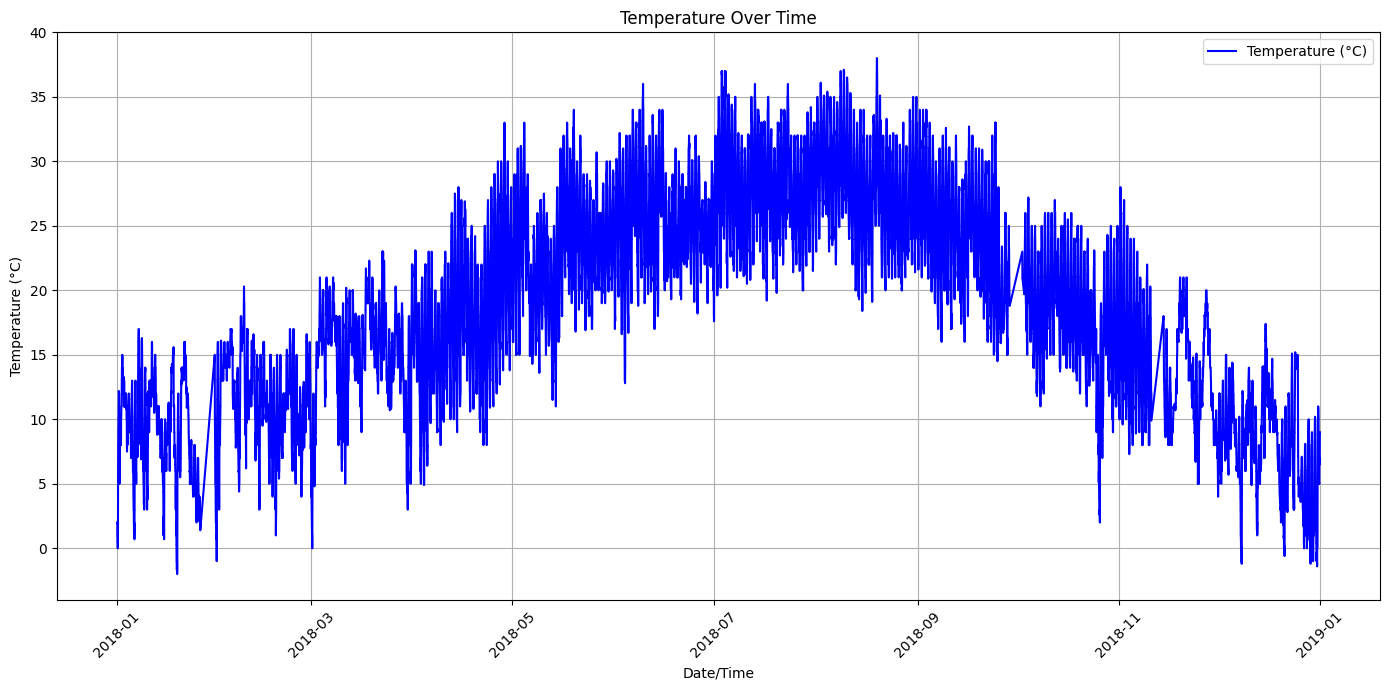

In [67]:
plt.figure(figsize=(14, 7))
plt.plot(df['Date/Time'], df['Temperature (°C)'], label='Temperature (°C)', color='b')

plt.xlabel('Date/Time')
plt.ylabel('Temperature (°C)')
plt.title('Temperature Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

**We have Wind Direction column, to create what?:**

"Effective Theoretical Power(kWh)": to determine ideal power we make use of at every wind direction
but first we have to discover if there is a yaw system, at this case the wind direction would not be relevent to us

#### Determine Yaw system existance
**Algorithm for finding a yaw system**

1) Discover if our data covers all wind directions to be able to test it

2) plot a scatter plot that draws a relation between power and wind direction, to determine if yaw system exists, if so the power output would be always high whatever the wind direction

3) plot a scatter plot that draws a relation between power and wind speed, to make sure if we have optimal wind direction where wind speed is always high or variating wind speed with different wind directions

A box plot can substitute for this

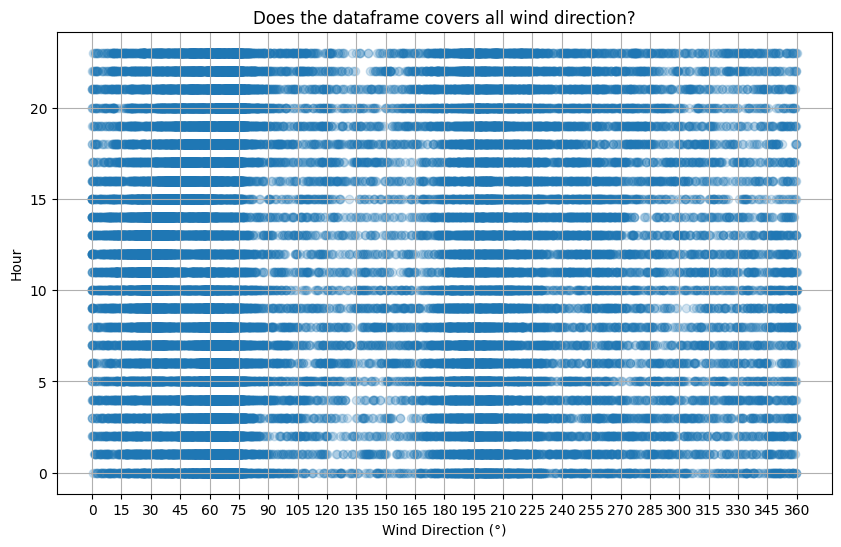

In [68]:
# Plot wind direcion vs wind power
plt.figure(figsize=(10, 6))
plt.scatter(df['Wind Direction (°)'], df['Hour'], alpha=0.2)
plt.title('Does the dataframe covers all wind direction?')
plt.xlabel('Wind Direction (°)')
plt.xticks(list(range(0, 365, 15)))
plt.ylabel('Hour')
plt.grid(True)
plt.show()

The answer is: **Nearly Yes**



**Evaluate the cut-in speed and rated velocity:**



In [69]:
# Determine the cut-in speed based on theoretical power curve
cut_in_speed = df[df['Theoretical_Power_Curve (KWh)'] > 0]['Wind Speed (m/s)'].min()
cut_in_speed = round(cut_in_speed, 1)
# Filter data based on this cut-in speed
filtered_data = df[df['Wind Speed (m/s)'] >= cut_in_speed]

# Determine the maximum power output
max_power = df['LV ActivePower (kW)'].max()

# Determine the least wind speed at which the maximum power is reached
rated_velocity = df[df['LV ActivePower (kW)'] == max_power]['Wind Speed (m/s)'].min()
rated_velocity = round(rated_velocity,1 )
print("The cut-in speed is " + str(cut_in_speed))
print("The rated velocity is " + str(rated_velocity))

The cut-in speed is 3.0
The rated velocity is 17.9


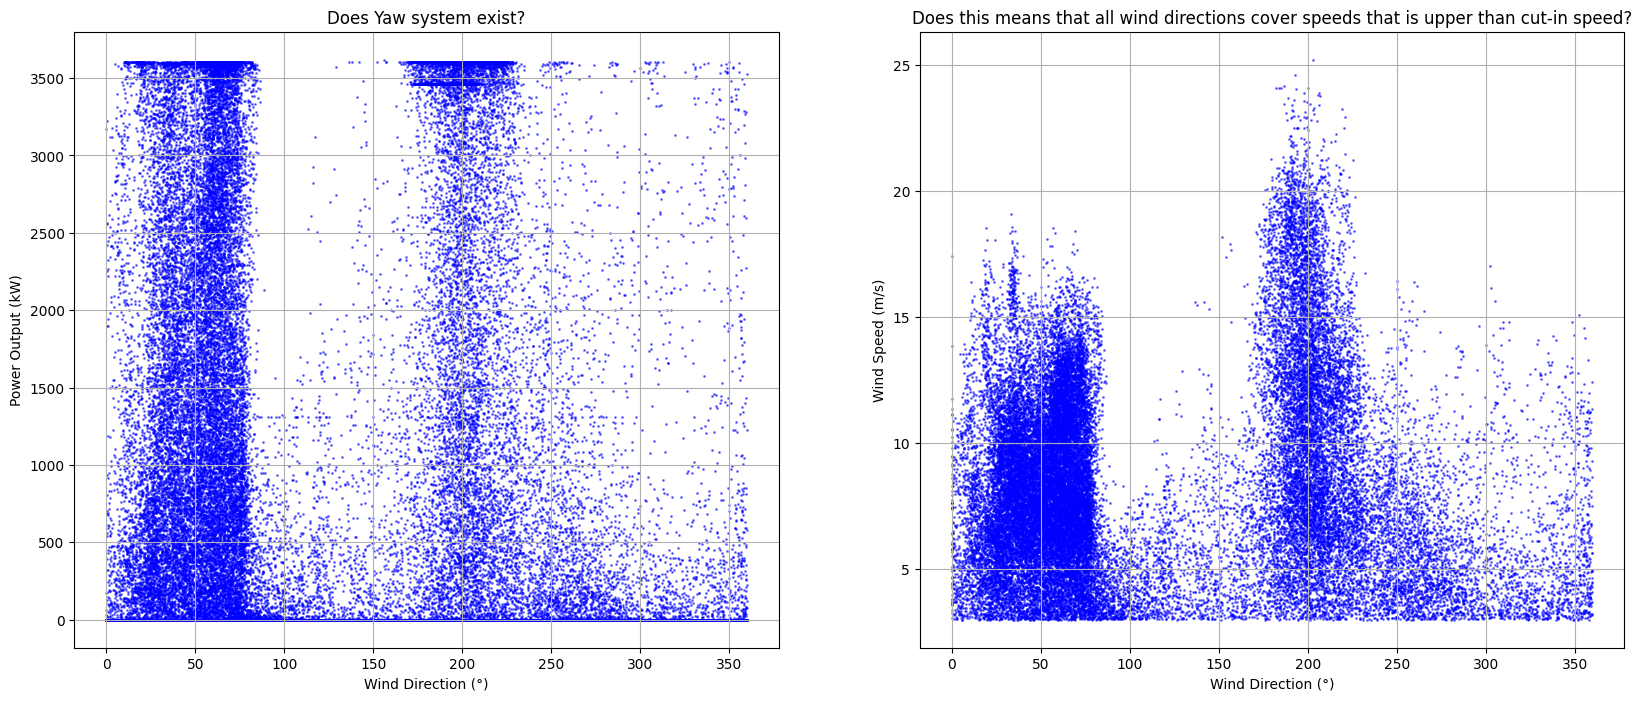

In [70]:
import matplotlib.pyplot as plt

filtered_df = df[df['Wind Speed (m/s)'] > cut_in_speed]

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

axes[0].scatter(df['Wind Direction (°)'], df['LV ActivePower (kW)'], alpha=0.5, c='blue', s=1)
axes[0].set_title('Does Yaw system exist?')
axes[0].set_xlabel('Wind Direction (°)')
axes[0].set_ylabel('Power Output (kW)')
axes[0].grid(True)

axes[1].scatter(filtered_df['Wind Direction (°)'], filtered_df['Wind Speed (m/s)'], alpha=0.5, c='blue', s=1)
axes[1].set_title('Does this means that all wind directions cover speeds that is upper than cut-in speed?')
axes[1].set_xlabel('Wind Direction (°)')
axes[1].set_ylabel('Wind Speed (m/s)')
axes[1].grid(True)

plt.show()

**Notes from the figures:**

- There are no high speeds at some wind directions, but our data covers all wind directions. This is scientifically possible due to various meteorological and geographical factors.
- The stakeholder uses the wind turbine at the optimal angle, as both graphs are nearly the same.
- Determining the existence of a yaw system would be more challenging. Why? The yaw system is used to keep the wind turbine direction parallel to the actual wind direction. From the right graph, we have high wind speeds only at ranges (0°, 70°) and (190°, 210°). So if a yaw system existed, it would operate the yaw mechanism rarely, i.e., we would not monitor its operation.

**But**... We already know the wind directions with the highest wind speeds, so we can develop a feature that measures Effective Theoretical Power.

**Algorithm for making Effective Theoretical Power**

1- Determine the optimal wind direction, from the graph it's 60 and 210

2- Determine Deviation from Optimal Wind Direction:

     - Determine the wind direction deviation from the optimal wind direction

     - Making the deviation from turbine axis divided by 360 to determine deviation percentage

     - Then subtracting this deviation percentage from 1 to get the "usability"
     
3- Multiply usability with Theoretical Power



In [71]:
def get_deviation(wind_direction):
    optimal_angles = [60, 210]
    deviations = [min(abs(wind_direction - angle), abs(wind_direction - angle + 360), abs(wind_direction - angle - 360)) for angle in optimal_angles]
    return min(deviations)
df['Effective Theoretical Power(kWh)'] = (100 - ((df['Wind Direction (°)'].apply(get_deviation) / 360) * 100)) * df['Theoretical_Power_Curve (KWh)']
df.head()

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°),Month,week,day,Hour,Seasons,...,wind_mean_1h,wind_std_1h,TI_1h,wind_max_1h,v2,v3,regime,Day/Night,Temperature (°C),Effective Theoretical Power(kWh)
0,2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904,1,1,1,0,Winter,...,5.311336,0.000000,0.000000,NaN,28.210291,149.834333,partial,1,2.0,35851.134228
1,2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113,1,1,1,0,Winter,...,5.491751,0.255146,0.046460,NaN,32.173476,182.493326,partial,1,2.0,43522.711755
2,2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789,1,1,1,0,Winter,...,5.399847,0.240602,0.044557,NaN,27.207040,141.912921,partial,1,2.0,32296.507987
3,2018-01-01 00:30:00,419.645905,5.659674,516.127569,271.258087,1,1,1,0,Winter,...,5.464803,0.235522,0.043098,NaN,32.031912,181.290183,partial,1,2.0,42830.260341
4,2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286,1,1,1,0,Winter,...,5.487431,0.210150,0.038297,NaN,31.113425,173.548848,partial,1,2.0,41566.071686


In [72]:
print(df.columns)


Index(['Date/Time', 'LV ActivePower (kW)', 'Wind Speed (m/s)',
       'Theoretical_Power_Curve (KWh)', 'Wind Direction (°)', 'Month', 'week',
       'day', 'Hour', 'Seasons', 'hour_sin', 'hour_cos', 'month_sin',
       'month_cos', 'wind_u', 'wind_v', 'wind_mean_1h', 'wind_std_1h', 'TI_1h',
       'wind_max_1h', 'v2', 'v3', 'regime', 'Day/Night', 'Temperature (°C)',
       'Effective Theoretical Power(kWh)'],
      dtype='object')


#### Feature importance

In [73]:
df.isna().sum()

Date/Time                           0
LV ActivePower (kW)                 0
Wind Speed (m/s)                    0
Theoretical_Power_Curve (KWh)       0
Wind Direction (°)                  0
Month                               0
week                                0
day                                 0
Hour                                0
Seasons                             0
hour_sin                            0
hour_cos                            0
month_sin                           0
month_cos                           0
wind_u                              0
wind_v                              0
wind_mean_1h                        0
wind_std_1h                         0
TI_1h                               0
wind_max_1h                         5
v2                                  0
v3                                  0
regime                              0
Day/Night                           0
Temperature (°C)                    0
Effective Theoretical Power(kWh)    0
dtype: int64

In [74]:
df.dropna(subset=['wind_max_1h'], inplace=True)

In [75]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Columns to one-hot encode
categorical_cols = ['Seasons', 'regime', 'Day/Night']

# 1. One-hot encode categorical columns
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# 2. Drop unnecessary columns
df = df.drop(columns=['Date/Time'])

# 3. Separate target
y = df['LV ActivePower (kW)']
X = df.drop(columns=['LV ActivePower (kW)'])

# 4. Scale numeric columns only
numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns
scaler = StandardScaler()
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

# 5. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


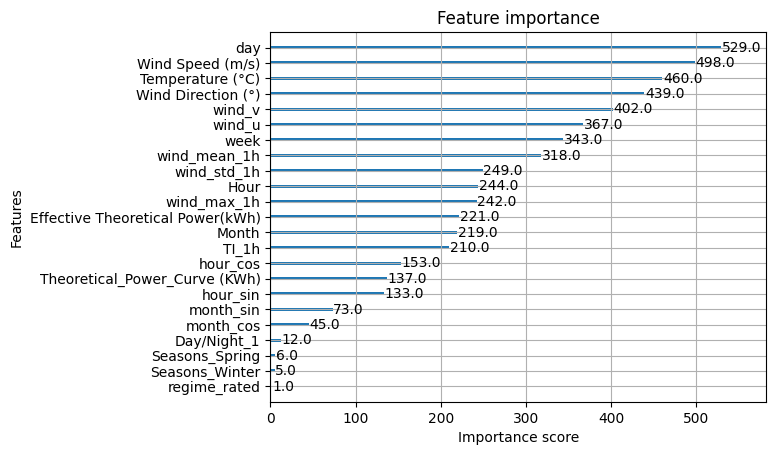

In [76]:
import matplotlib.pyplot as plt
import xgboost as xgb

# Train XGBoost model
model = xgb.XGBRegressor()
model.fit(X_train, y_train)
# Train XGBoost model
model = xgb.XGBRegressor()
model.fit(X_train, y_train)
importances = model.feature_importances_
feature_names = X.columns


# Plot feature importances
xgb.plot_importance(model)
plt.show()

In [77]:
df.columns

Index(['LV ActivePower (kW)', 'Wind Speed (m/s)',
       'Theoretical_Power_Curve (KWh)', 'Wind Direction (°)', 'Month', 'week',
       'day', 'Hour', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos',
       'wind_u', 'wind_v', 'wind_mean_1h', 'wind_std_1h', 'TI_1h',
       'wind_max_1h', 'v2', 'v3', 'Temperature (°C)',
       'Effective Theoretical Power(kWh)', 'Seasons_Spring', 'Seasons_Summer',
       'Seasons_Winter', 'regime_partial', 'regime_rated', 'Day/Night_1'],
      dtype='object')

In [78]:
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = df.select_dtypes(exclude=[np.number]).columns.tolist()

print(f"We have {len(numeric_features)} numerical features : {numeric_features}")
print(f"\nWe have {len(categorical_features)} categorical features : {categorical_features}")


We have 22 numerical features : ['LV ActivePower (kW)', 'Wind Speed (m/s)', 'Theoretical_Power_Curve (KWh)', 'Wind Direction (°)', 'Month', 'week', 'day', 'Hour', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'wind_u', 'wind_v', 'wind_mean_1h', 'wind_std_1h', 'TI_1h', 'wind_max_1h', 'v2', 'v3', 'Temperature (°C)', 'Effective Theoretical Power(kWh)']

We have 6 categorical features : ['Seasons_Spring', 'Seasons_Summer', 'Seasons_Winter', 'regime_partial', 'regime_rated', 'Day/Night_1']


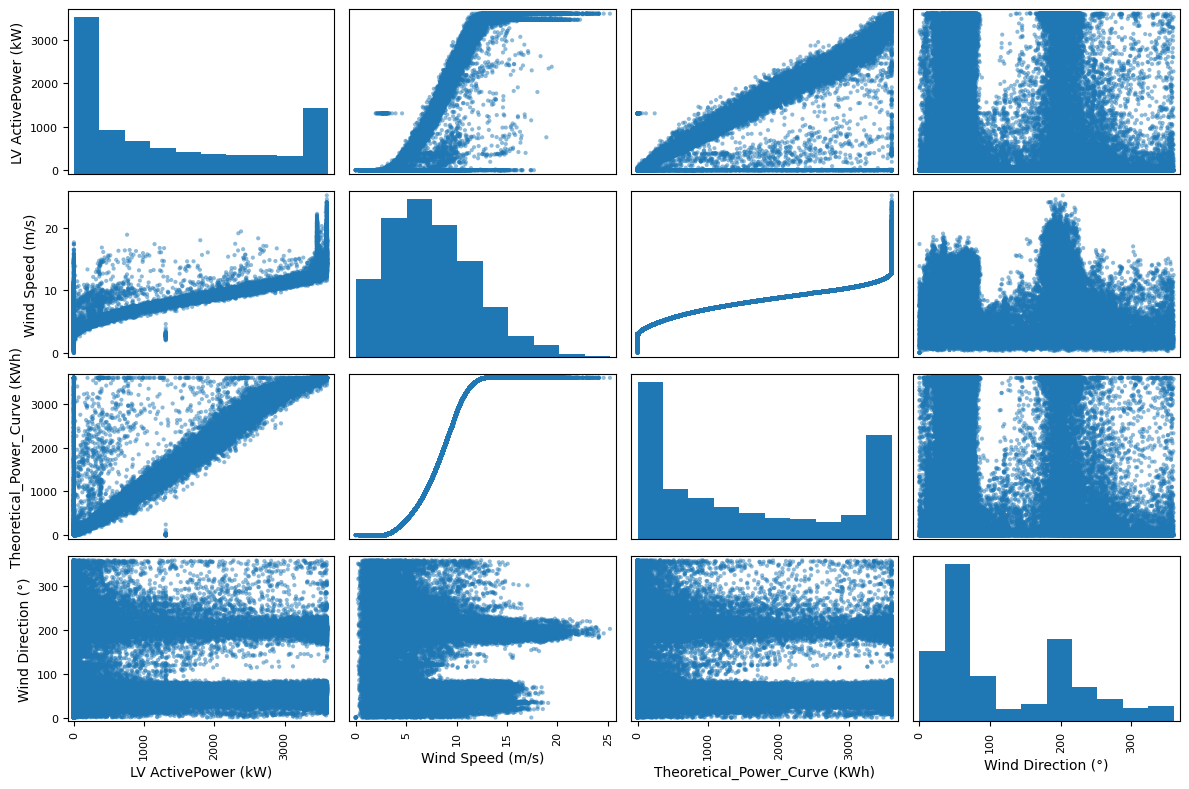

In [79]:
columns_needed = ['LV ActivePower (kW)', 'Wind Speed (m/s)', 'Theoretical_Power_Curve (KWh)','Wind Direction (°)']
pd.plotting.scatter_matrix(df[columns_needed], figsize=(12, 8))
plt.tight_layout()
plt.show()

array([[<Axes: title={'center': 'LV ActivePower (kW)'}>,
        <Axes: title={'center': 'Wind Speed (m/s)'}>],
       [<Axes: title={'center': 'Theoretical_Power_Curve (KWh)'}>,
        <Axes: title={'center': 'Wind Direction (°)'}>]], dtype=object)

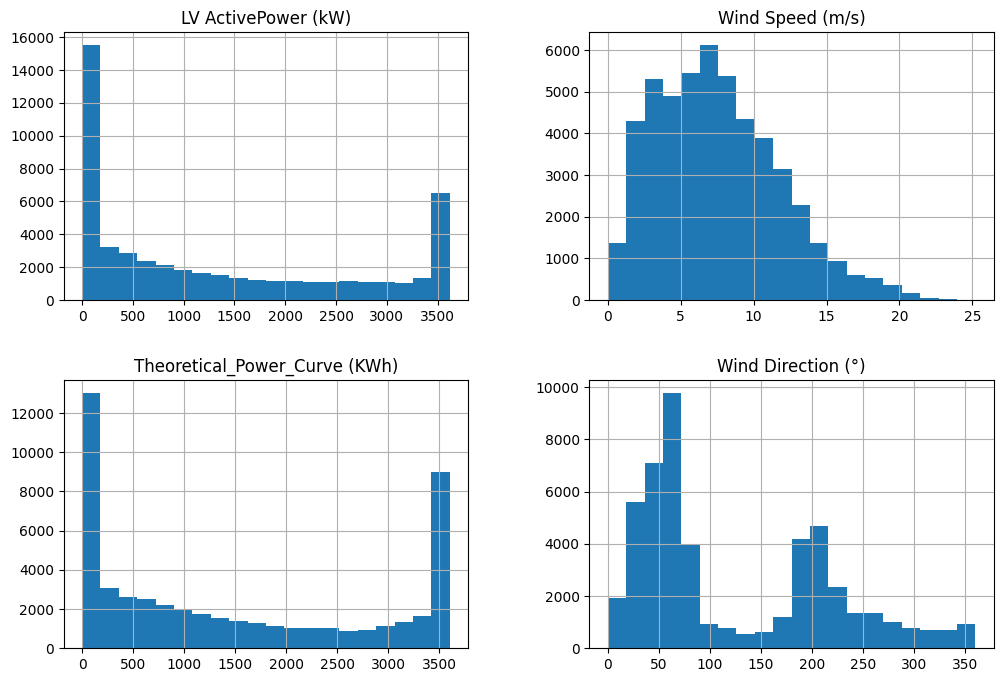

In [80]:
df[columns_needed].hist(bins=20, figsize=(12,8))

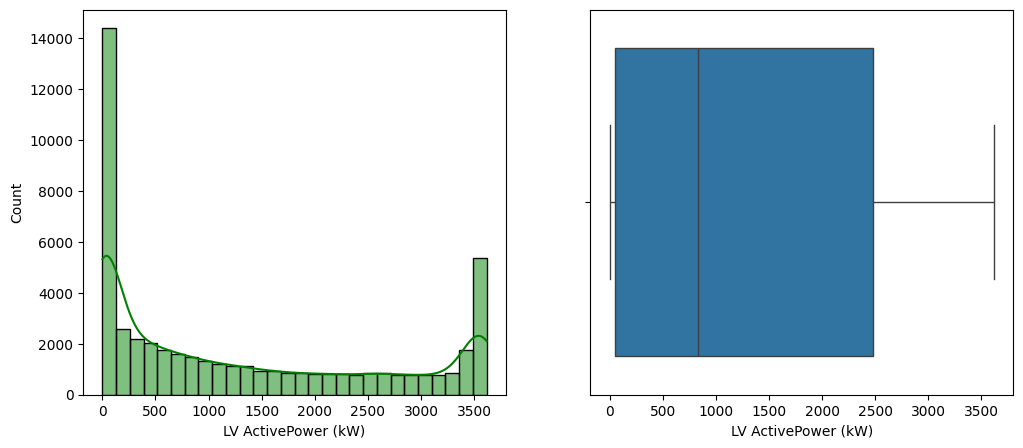

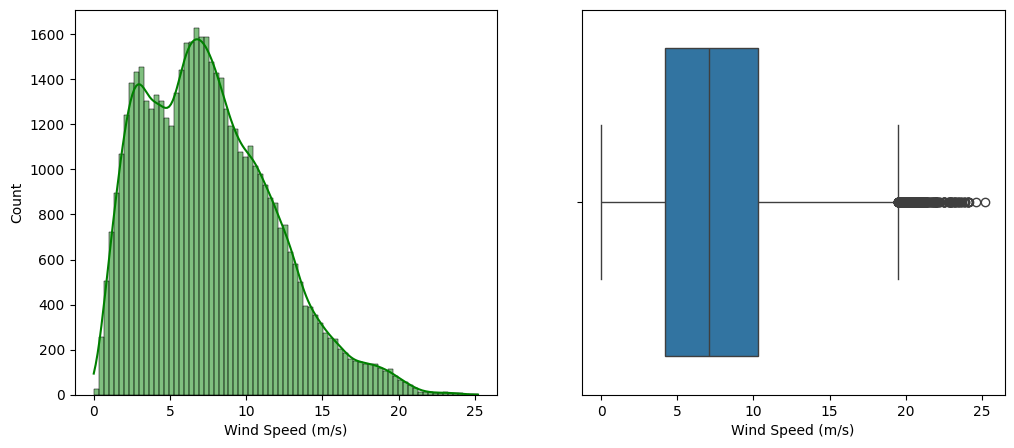

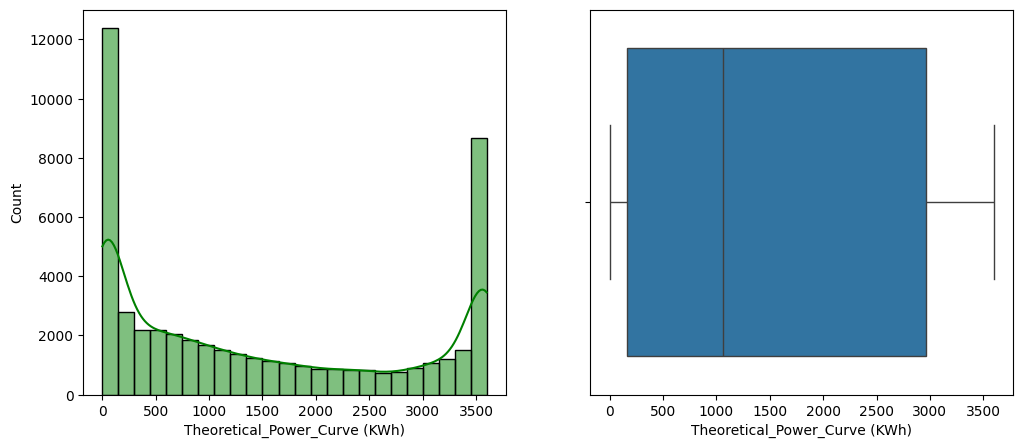

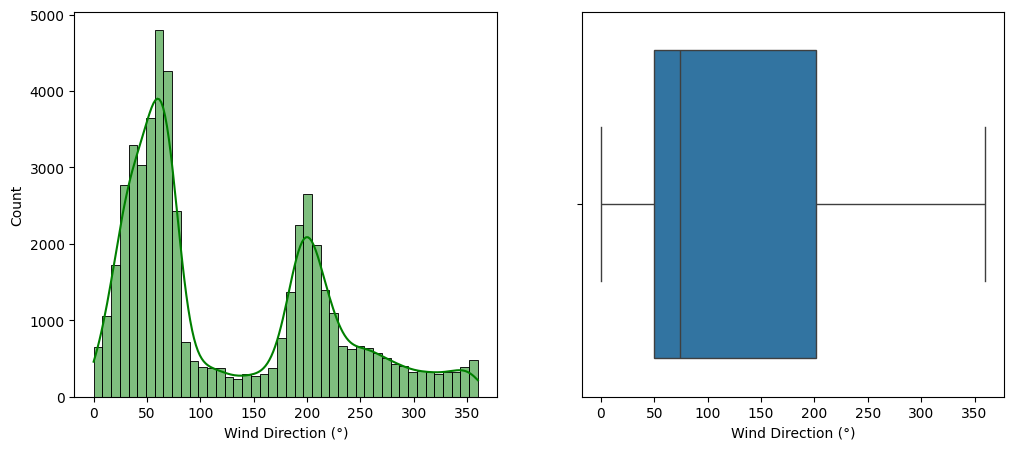

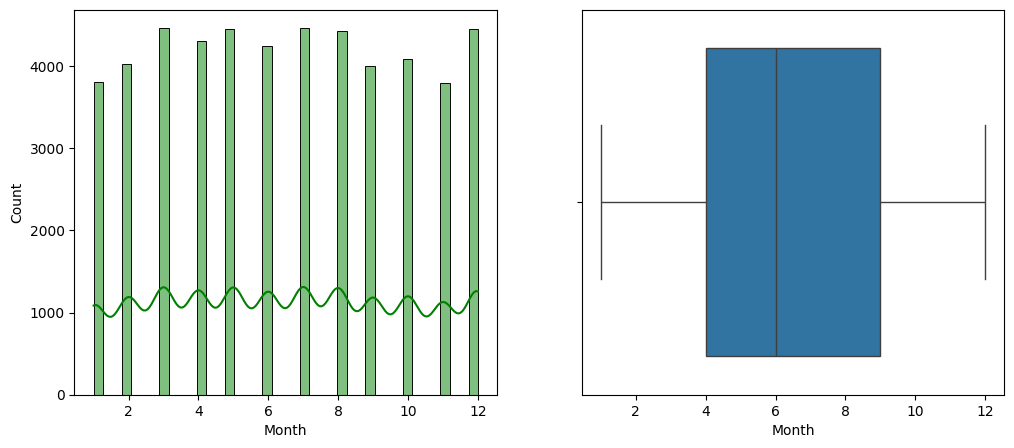

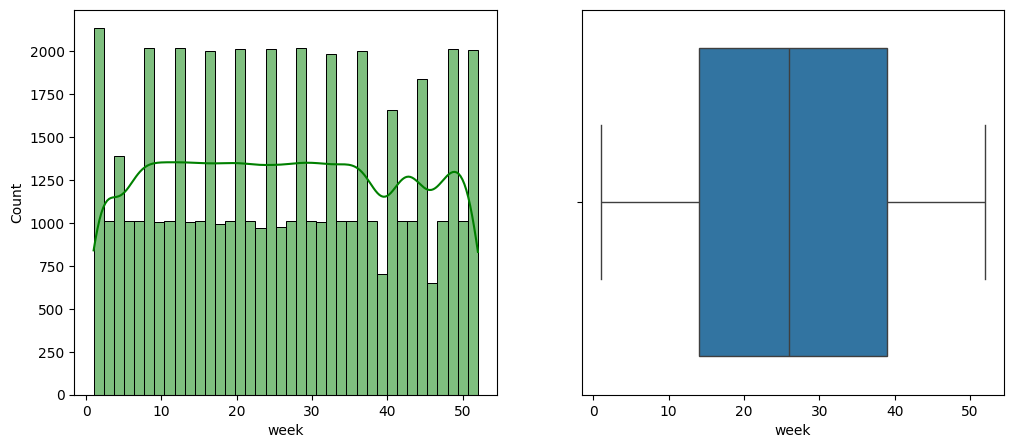

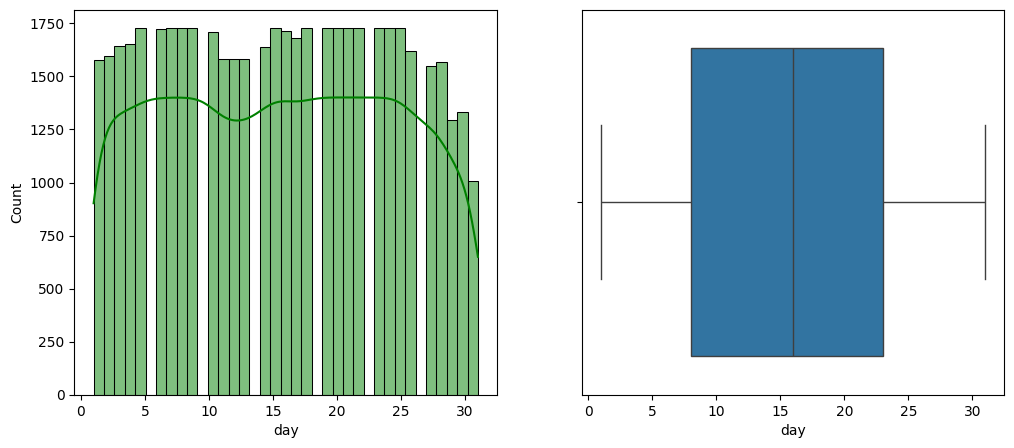

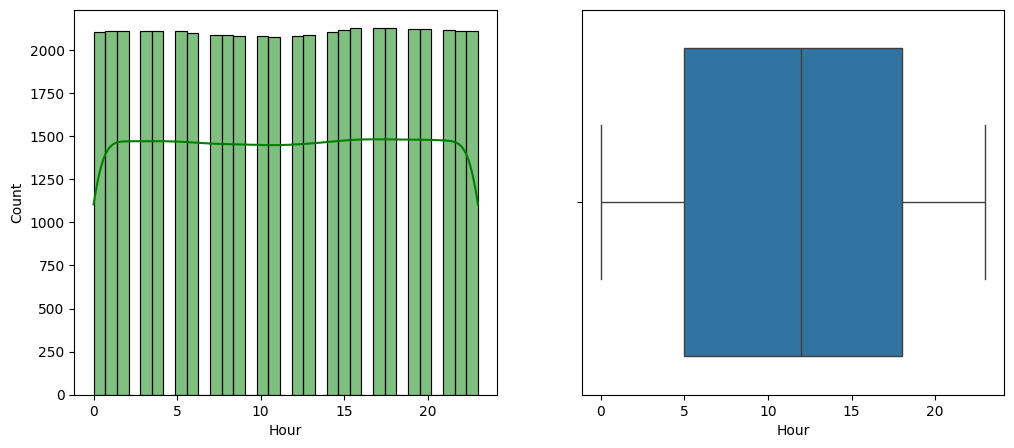

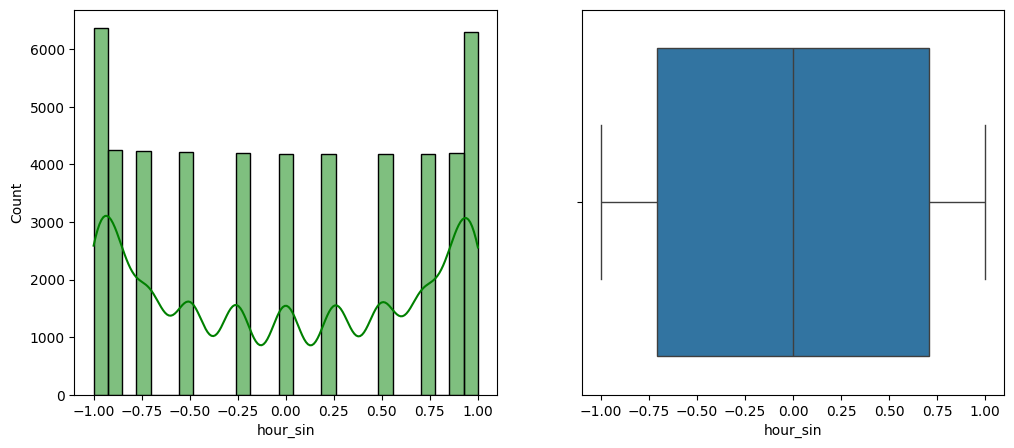

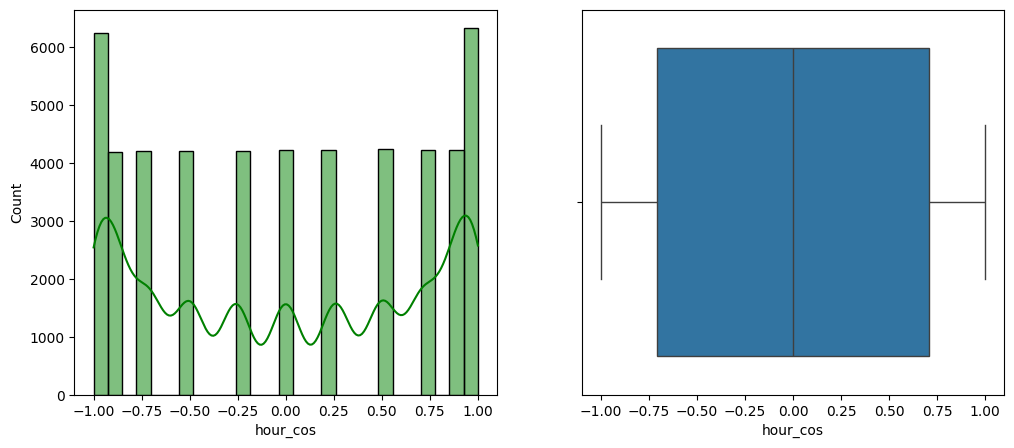

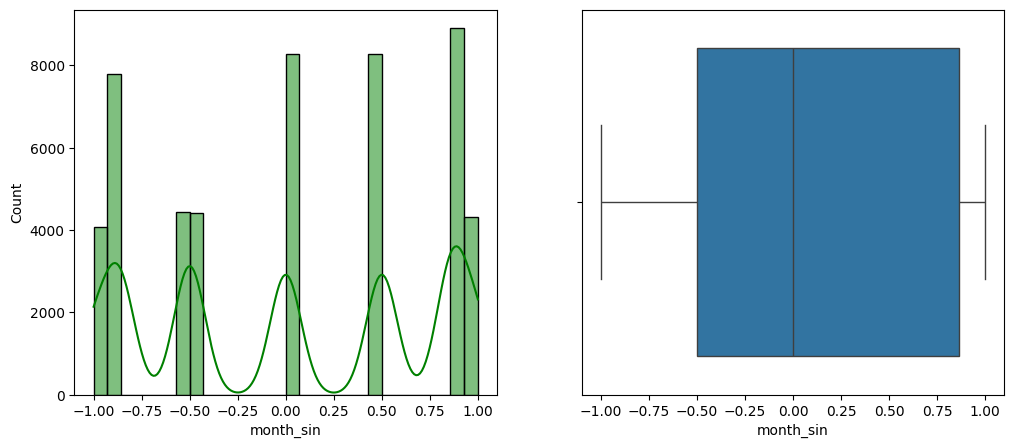

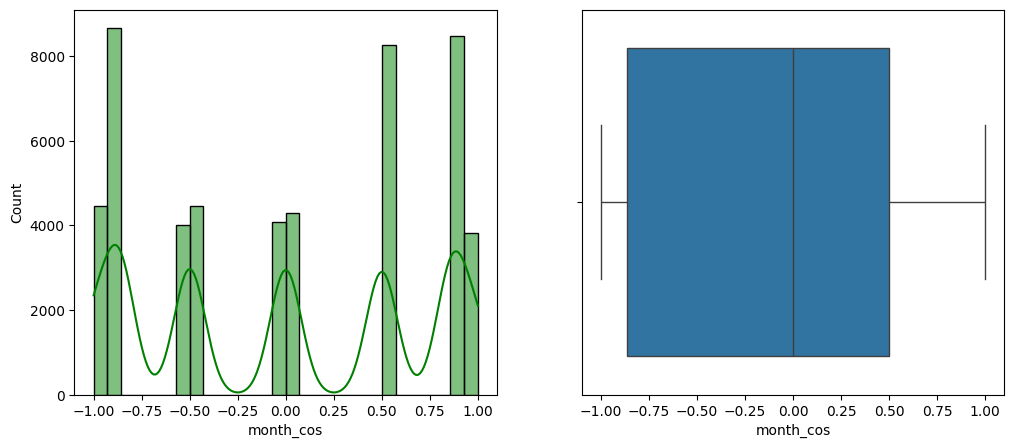

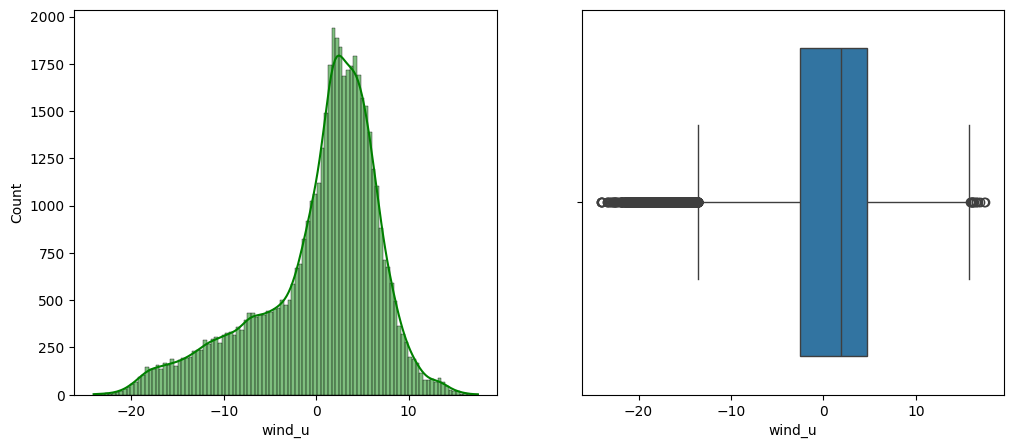

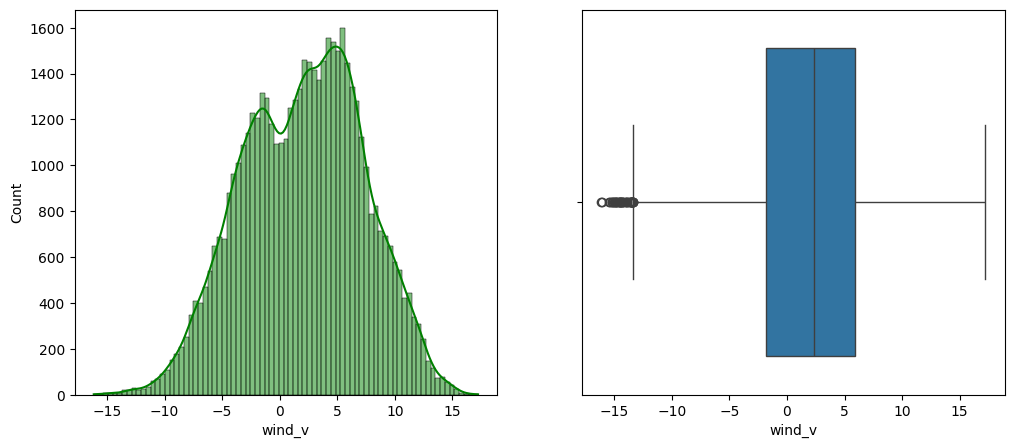

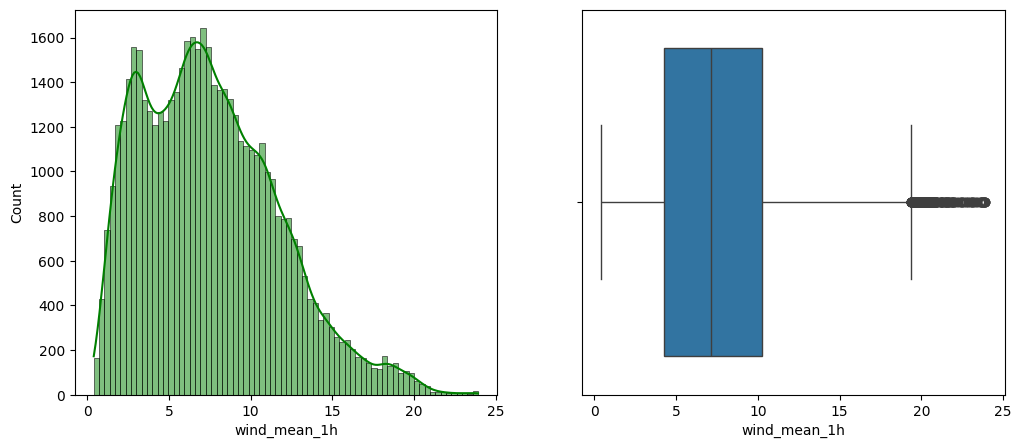

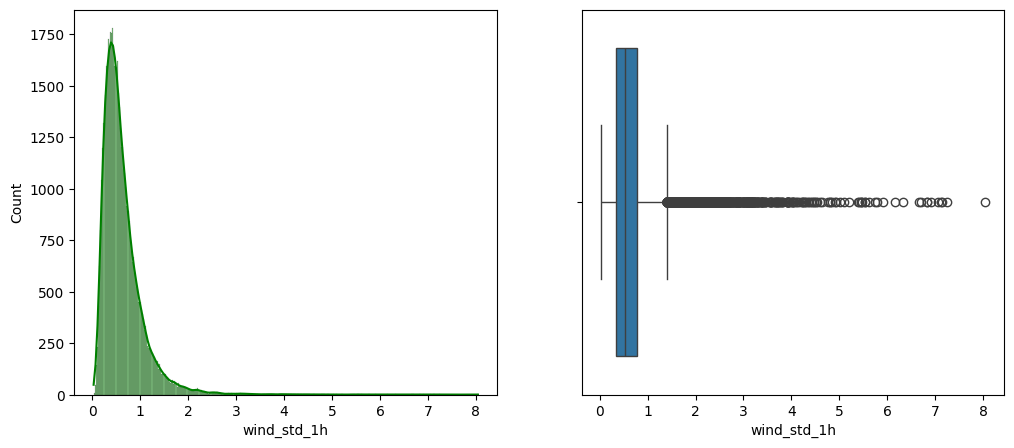

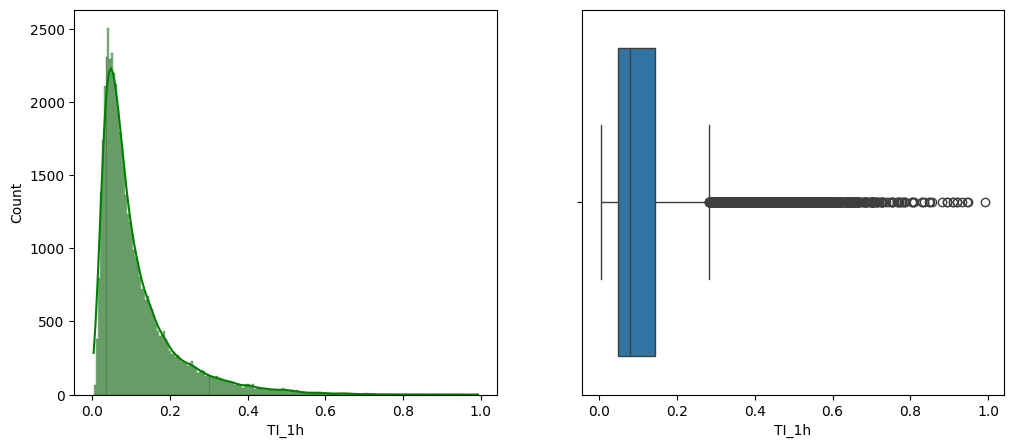

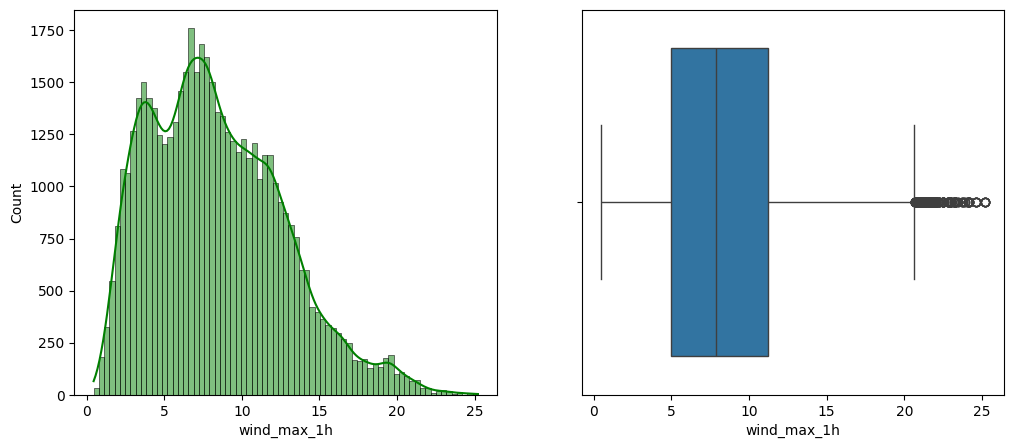

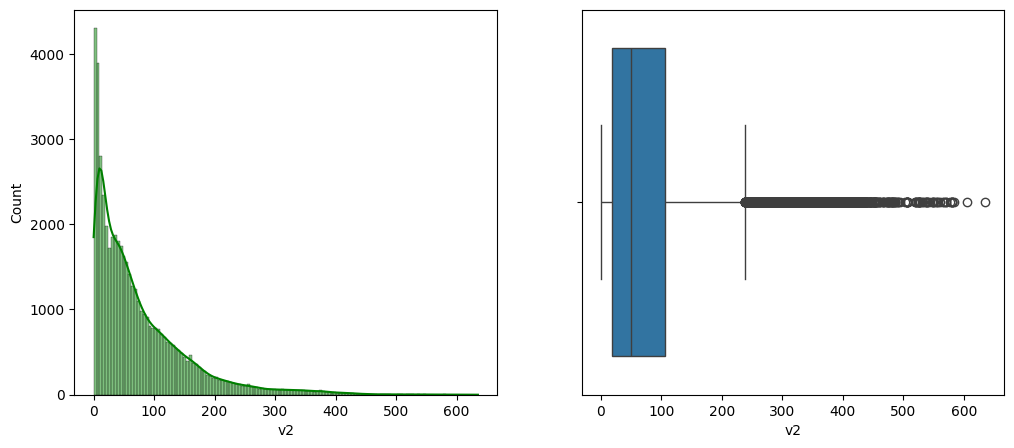

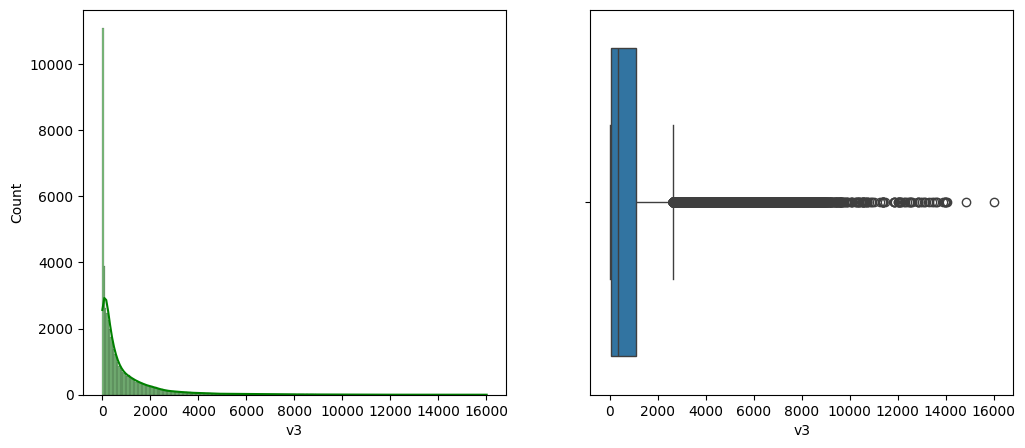

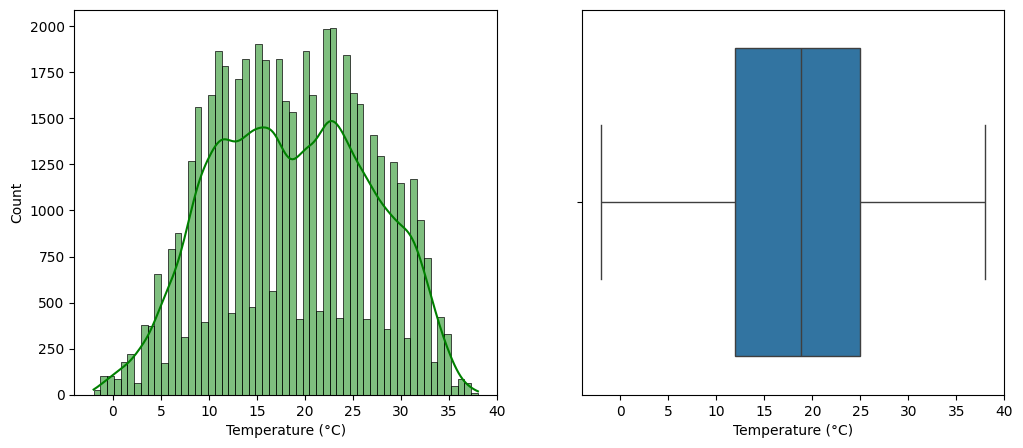

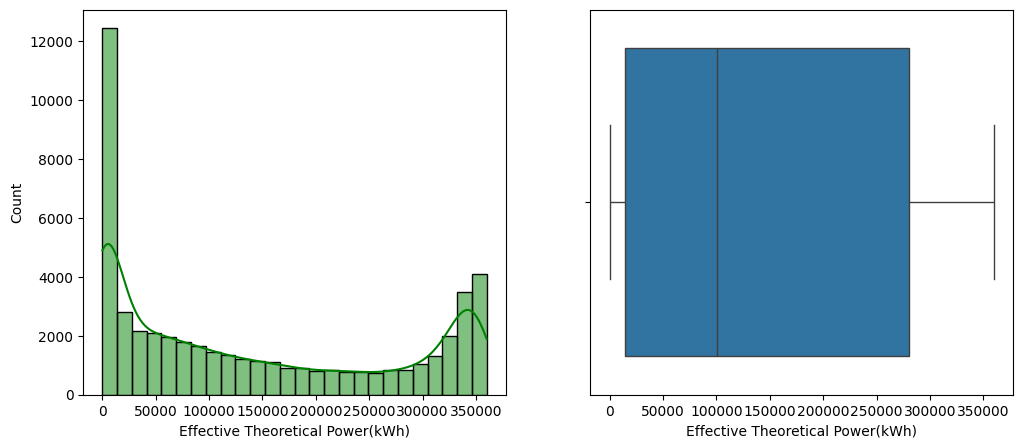

In [81]:
for col in df.describe().columns:
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    sns.histplot(df[col], ax=ax[0], color='green', kde=True)
    sns.boxplot(x=df[col], ax=ax[1])
    plt.show()

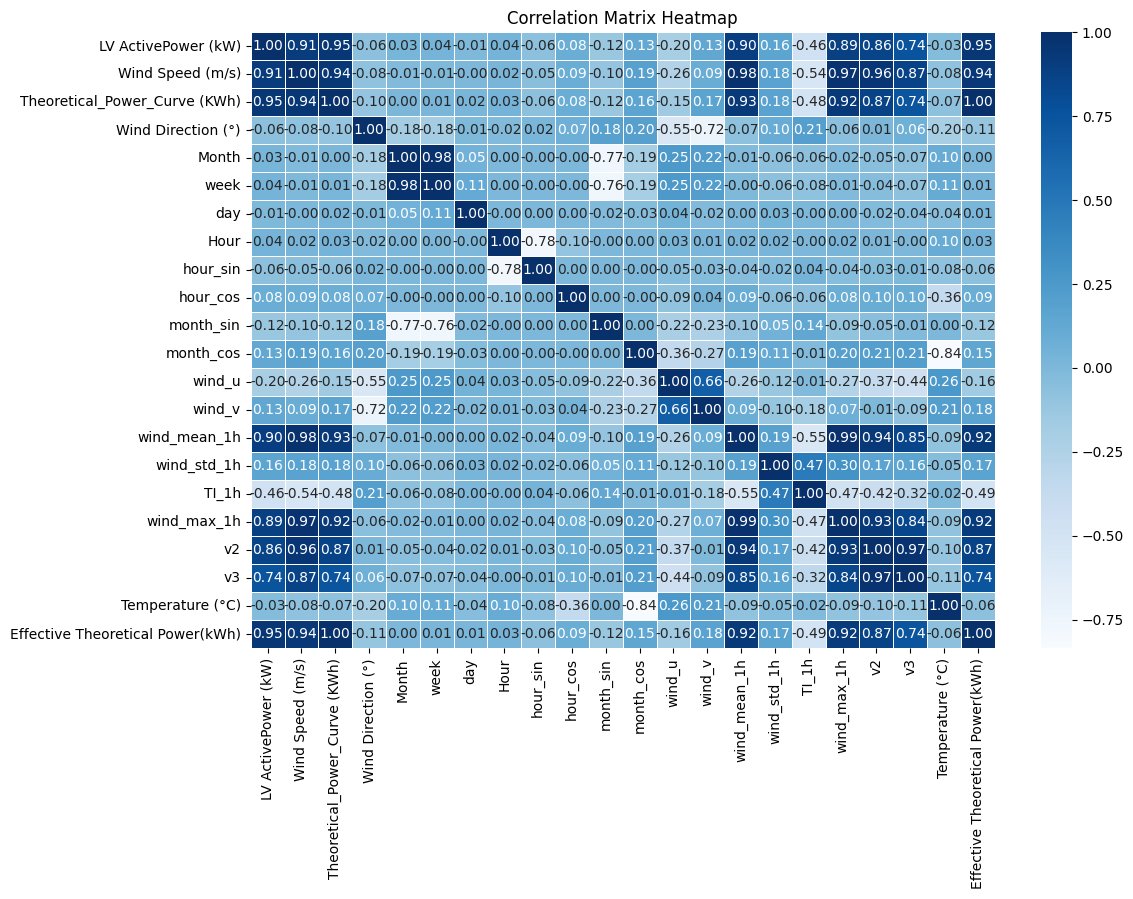

In [82]:
corr_matrix = df[numeric_features].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="Blues", linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()

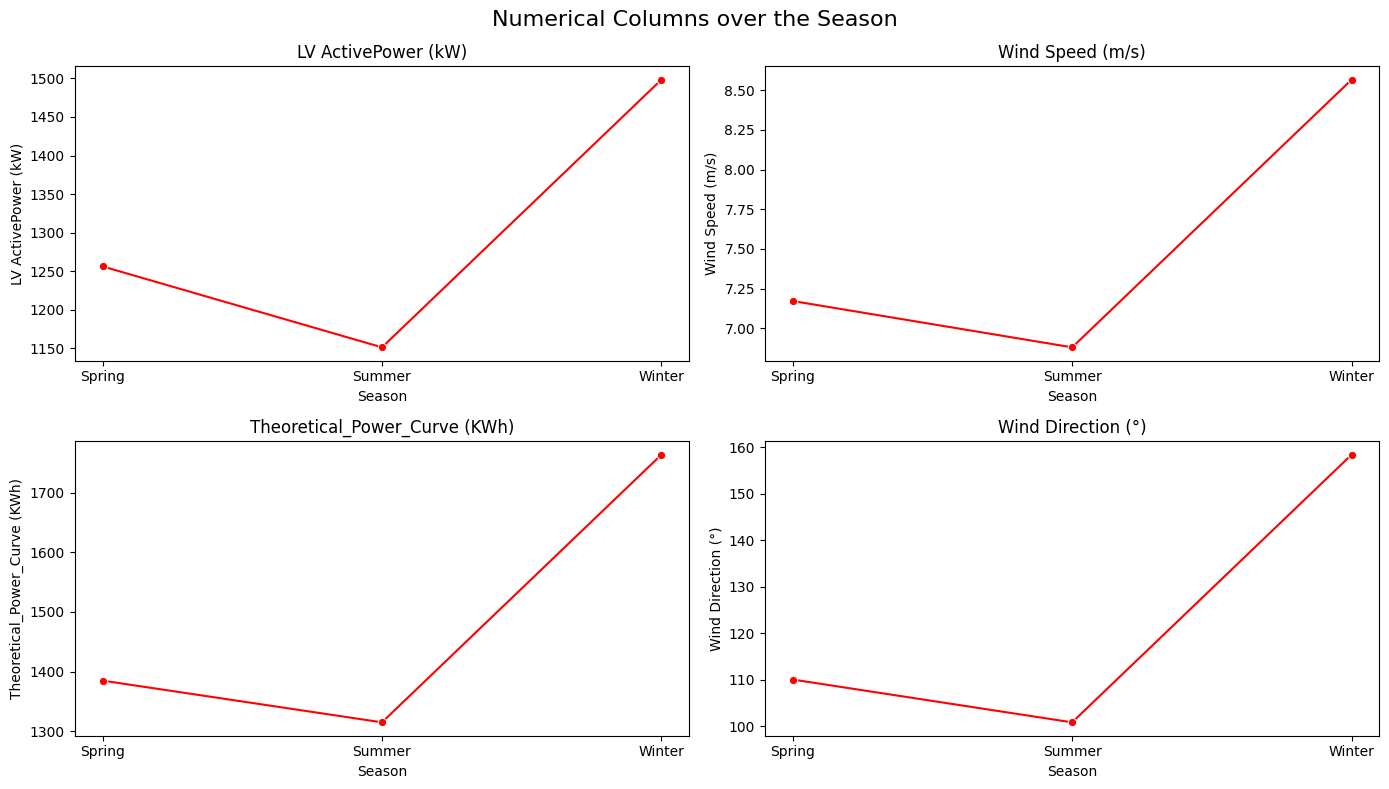

In [85]:


# Step 1: Clean column names
df.columns = df.columns.str.strip()

# Step 2: Handle Seasons (if one-hot encoded)
season_cols = [c for c in df.columns if c.startswith('Seasons_')]
if season_cols:
    # Create a single 'Season' column from one-hot encoding
    df['Season'] = df[season_cols].idxmax(axis=1).str.replace('Seasons_', '')
else:
    # If 'Seasons' already exists, just rename for consistency
    df['Season'] = df['Seasons']

# Step 3: Define numerical columns to plot
columns_needed = ['LV ActivePower (kW)', 'Wind Speed (m/s)',
                  'Theoretical_Power_Curve (KWh)', 'Wind Direction (°)']

# Step 4: Plot
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))

for idx, col in enumerate(columns_needed):
    row_idx = idx // 2
    col_idx = idx % 2
    # Aggregate by Season (mean)
    season_avg = df.groupby('Season')[col].mean().reset_index()
    sns.lineplot(x='Season', y=col, data=season_avg, ax=axes[row_idx, col_idx], color='red', marker='o')
    axes[row_idx, col_idx].set_title(col)

fig.suptitle('Numerical Columns over the Season', fontsize=16)
plt.tight_layout()
plt.show()


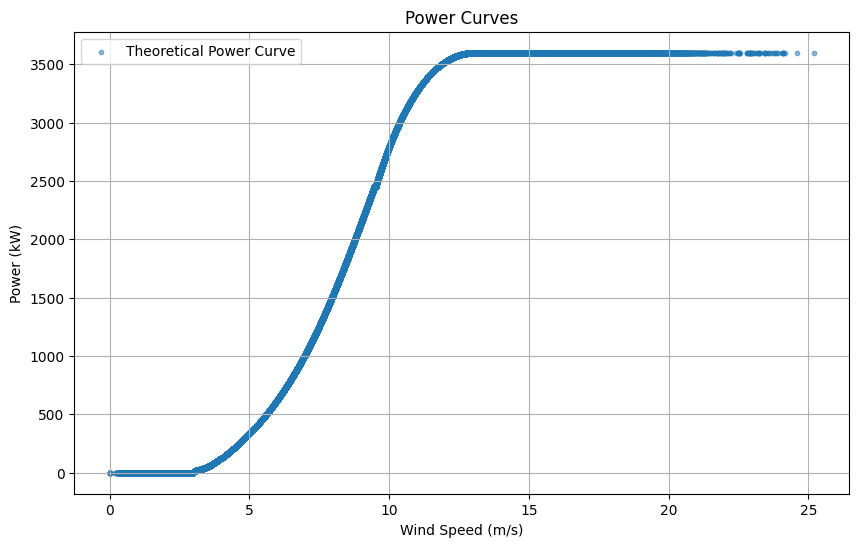

In [86]:
# Plot the power curves
plt.figure(figsize=(10, 6))
plt.scatter(df['Wind Speed (m/s)'], df['Theoretical_Power_Curve (KWh)'], s=10, alpha=0.5, label='Theoretical Power Curve')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Power (kW)')
plt.title('Power Curves')
plt.legend()
plt.grid(True)
plt.show()

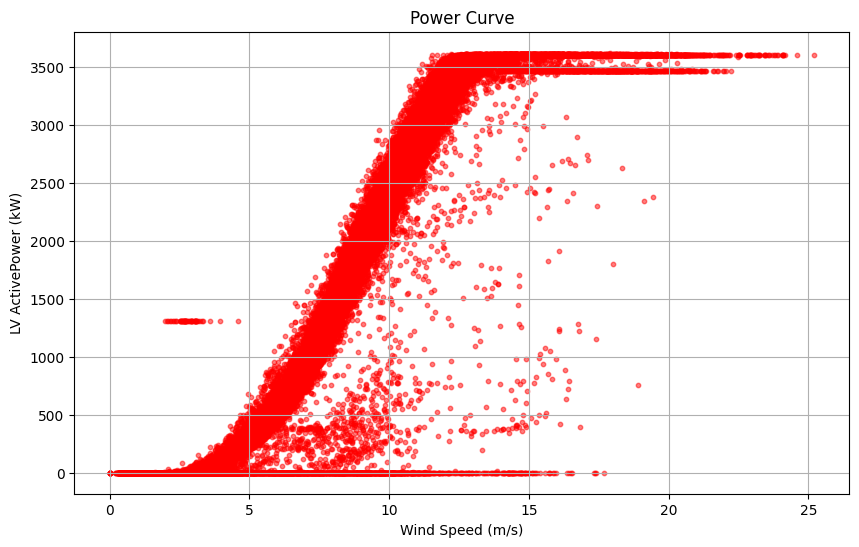

In [87]:
# Plot the power curve
plt.figure(figsize=(10, 6))
plt.scatter(df['Wind Speed (m/s)'], df['LV ActivePower (kW)'],color='red', s=10, alpha=0.5)
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('LV ActivePower (kW)')
plt.title('Power Curve')
plt.grid(True)
plt.show()

## Model Evaluation

In [88]:
df.dropna(subset=['wind_max_1h'], inplace=True)

In [89]:
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor,AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor,XGBRFRegressor
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
model_name=[]
r2score=[]
rmse=[]
models=[
    GradientBoostingRegressor(random_state=42),
    SVR(),
    RandomForestRegressor(random_state=42),
    LinearRegression(),
    ExtraTreesRegressor(random_state=42),
    AdaBoostRegressor(random_state=42),
    DecisionTreeRegressor(random_state=42),
    XGBRegressor(random_state=42),
    XGBRFRegressor(random_state=42),
    CatBoostRegressor(random_state=42,verbose=False)
]

for model in models:
    model.fit(X_train , y_train)
    y_pred = model.predict(X_test)
    model_name.append(model.__class__.__name__)
    r2score.append(str(r2_score( y_test , y_pred ) * 100 ))
    rmse.append(str(mean_squared_error( y_test , y_pred,squared=False )))
    models_df = pd.DataFrame({"Model-Name":model_name, "R2_score": r2score ,'RMSE':rmse})
models_df = models_df.astype({"R2_score": float, "RMSE": float})
models_df.sort_values("R2_score", ascending = False)

TypeError: got an unexpected keyword argument 'squared'

In [90]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor, XGBRFRegressor
from catboost import CatBoostRegressor
from sklearn.impute import SimpleImputer

# Impute missing values in X_train and X_test
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# List of models
models = [
    GradientBoostingRegressor(random_state=42),
    SVR(),
    RandomForestRegressor(random_state=42),
    LinearRegression(),
    ExtraTreesRegressor(random_state=42),
    AdaBoostRegressor(random_state=42),
    DecisionTreeRegressor(random_state=42),
    XGBRegressor(random_state=42),
    XGBRFRegressor(random_state=42),
    CatBoostRegressor(random_state=42, verbose=False)
]

# Lists to store results
model_names = []
r2_scores = []
rmses = []

# Train, predict, and evaluate
for model in models:
    model.fit(X_train_imputed, y_train)
    y_pred = model.predict(X_test_imputed)
    
    model_names.append(model.__class__.__name__)
    r2_scores.append(r2_score(y_test, y_pred) * 100)  # Percentage
    rmses.append(np.sqrt(mean_squared_error(y_test, y_pred)))

# Create results DataFrame
models_df = pd.DataFrame({
    "Model-Name": model_names,
    "R2_score": r2_scores,
    "RMSE": rmses
})

# Sort by R2_score descending
models_df.sort_values("R2_score", ascending=False, inplace=True)
models_df.reset_index(drop=True, inplace=True)

models_df


,Model-Name,R2_score,RMSE
0,CatBoostRegressor,98.329063,168.957231
1,XGBRegressor,98.260204,172.403422
2,ExtraTreesRegressor,97.908738,189.017006
3,RandomForestRegressor,97.113608,222.062060
4,GradientBoostingRegressor,94.954606,293.592024
5,XGBRFRegressor,94.348126,310.736976
6,DecisionTreeRegressor,94.340350,310.950667
7,LinearRegression,91.173679,388.317135
8,AdaBoostRegressor,86.481865,480.568275
9,SVR,15.031105,1204.832542


## Hyperparameters Tuning

In [91]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, make_scorer
import xgboost as xgb
import numpy as np

# Define custom scoring functions
def rmse_scorer(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Define the model
model = xgb.XGBRegressor(objective='reg:squarederror')

# Define the parameter distributions for Randomized Search with discrete values
param_distributions = {
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10], 
    'colsample_bylevel': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],  
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 1.0],
    'n_estimators': [900, 950, 1000],
    'subsample': [0.6, 0.7, 0.8, 0.9]
}

# Define the RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_distributions,
    n_iter=30,
    scoring=make_scorer(rmse_scorer, greater_is_better=False),
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Perform Randomized Search
random_search.fit(X_train, y_train)

# Get the best parameters
best_params = random_search.best_params_
print(f"Best parameters: {best_params}")

# Train the best model
best_model = random_search.best_estimator_
best_model.fit(X_train, y_train)

# Evaluate the best model on the test set
predictions = best_model.predict(X_test)
rmse = rmse_scorer(y_test, predictions)
r2 = r2_score(y_test, predictions)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END colsample_bylevel=0.9, learning_rate=0.5, max_depth=3, n_estimators=950, subsample=0.8; total time=   8.4s[CV] END colsample_bylevel=0.9, learning_rate=0.5, max_depth=3, n_estimators=950, subsample=0.8; total time=   8.4s

[CV] END colsample_bylevel=0.9, learning_rate=0.5, max_depth=3, n_estimators=950, subsample=0.8; total time=   9.3s
[CV] END colsample_bylevel=0.6, learning_rate=1.0, max_depth=6, n_estimators=1000, subsample=0.8; total time=  16.5s
[CV] END colsample_bylevel=0.6, learning_rate=1.0, max_depth=6, n_estimators=1000, subsample=0.8; total time=  17.6s
[CV] END colsample_bylevel=0.6, learning_rate=1.0, max_depth=6, n_estimators=1000, subsample=0.8; total time=  18.0s
[CV] END colsample_bylevel=1.0, learning_rate=0.05, max_depth=7, n_estimators=900, subsample=0.9; total time=  23.6s
[CV] END colsample_bylevel=1.0, learning_rate=0.05, max_depth=7, n_estimators=900, subsample=0.9; total time=  25.4s
[CV] E

In [92]:
print(f"Root Mean Squared Error (RMSE) of the best model: {rmse}")
print(f"R² score of the best model: {r2}")

Root Mean Squared Error (RMSE) of the best model: 154.97064332266248
R² score of the best model: 0.9859425850302306


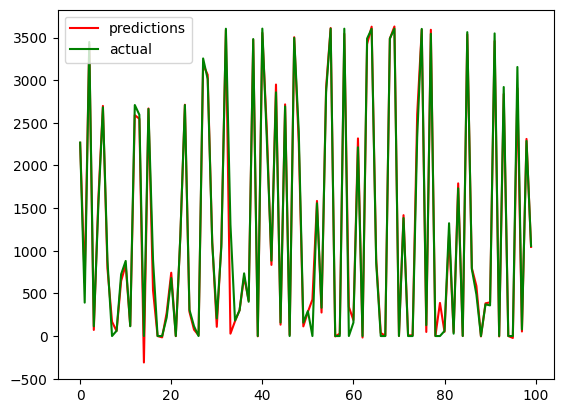

In [93]:
import matplotlib.pyplot as plt
plt.plot(predictions[:100], 'r', label="predictions")
plt.plot(y_test.to_numpy()[:100], 'g-', label="actual")
plt.legend()
plt.show()

#### Summary

- Model accuracy: XGBRegressor (R² = 98.2% & RMSE = 0.13)
- Yaw system existencce would be meaningless, as there is high wind speeds at specific angles
- Crafted features (Day/Night, Season, Temperature, Day, Hour, Week, Month, Effective Theoretical Power)
- Applied Day/Night with Winter & Summer Solstices to get high accuracy Day/Night timing

**Disclaimer:** Creating a temperature feature is not a good practice as temperatures vary greatly in different locations. However, [since there are a lot of WTs in izmir](https://tureb.com.tr/eng/lib/uploads/6c479498822929a9.pdf), it will probably help the model, at least until I know the accurate location of the turbines in Turkey, but when it comes to Day/Night the differences is not big when it comes to all possible locations.